In [14]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import norm, beta as beta_dist, invgamma

def bayesCpi_gibbs_sampler(X_f, X, y, num_iterations, 
                           a=1.0, b=1.0, 
                           a_e=2.0, b_e=2.0, 
                           a_beta=2.0, b_beta=2.0, 
                           tau_f2=1e6):
    """
    BayesCpi 模型的 Gibbs 采样算法

    参数：
    X_f: 固定效应的设计矩阵 (n x q)
    X: SNP 效应的设计矩阵 (n x p)
    y: 响应变量向量 (n,)
    num_iterations: 迭代次数
    a, b: Pi 的 Beta 分布超参数
    a_e, b_e: 残差方差的逆伽玛分布超参数
    a_beta, b_beta: 非零效应方差的逆伽玛分布超参数
    tau_f2: 固定效应回归系数的先验方差

    返回：
    beta_f_samples: 固定效应回归系数的采样 (num_iterations x q)
    beta_samples: SNP 效应回归系数的采样 (num_iterations x p)
    delta_samples: 指示变量的采样 (num_iterations x p)
    Pi_samples: Pi 的采样 (num_iterations,)
    sigma_e2_samples: 残差方差的采样 (num_iterations,)
    sigma_beta2_samples: 非零效应方差的采样 (num_iterations,)
    """
    n, p = X.shape
    q = X_f.shape[1]
    
    # 初始化参数
    beta_f = np.zeros(q)
    beta = np.zeros(p)
    delta = np.zeros(p, dtype=int)
    Pi = 0.5
    sigma_e2 = 1.0
    sigma_beta2 = 1.0
    
    # 存储采样结果
    beta_f_samples = np.zeros((num_iterations, q))
    beta_samples = np.zeros((num_iterations, p))
    delta_samples = np.zeros((num_iterations, p), dtype=int)
    Pi_samples = np.zeros(num_iterations)
    sigma_e2_samples = np.zeros(num_iterations)
    sigma_beta2_samples = np.zeros(num_iterations)
    
    # 预计算 X_f^T X_f
    X_fTX_f = X_f.T @ X_f
    
    for t in range(num_iterations):
        # 步骤1：更新固定效应回归系数 beta_f
        Sigma_beta_f_inv = (X_fTX_f / sigma_e2) + (1 / tau_f2) * np.eye(q)
        Sigma_beta_f = np.linalg.inv(Sigma_beta_f_inv)
        mu_beta_f = Sigma_beta_f @ (X_f.T @ (y - X @ beta)) / sigma_e2
        beta_f = np.random.multivariate_normal(mu_beta_f, Sigma_beta_f)
        
        # 步骤2：更新 SNP 效应回归系数 beta
        for j in range(p):
            if delta[j] == 1:
                X_j = X[:, j]
                # 计算残差
                residual = y - X_f @ beta_f - X @ beta + X_j * beta[j]
                tau_j2 = sigma_e2 / (X_j.T @ X_j + sigma_e2 / sigma_beta2)
                mu_j = tau_j2 * (X_j.T @ residual) / sigma_e2
                beta[j] = np.random.normal(mu_j, np.sqrt(tau_j2))
            else:
                beta[j] = 0.0
        
        # 步骤3：更新指示变量 delta
        for j in range(p):
            if beta[j] != 0:
                delta[j] = 1
            else:
                # 计算 p(delta_j = 1 | ...)
                prob_1 = Pi * norm.pdf(0, loc=0, scale=np.sqrt(sigma_beta2))
                prob_0 = 1 - Pi
                prob_delta_1 = prob_1 / (prob_1 + prob_0 + 1e-10)  # 加小数防止除零
                delta[j] = np.random.binomial(1, prob_delta_1)
                if delta[j] == 0:
                    beta[j] = 0.0
        
        # 步骤4：更新 Pi
        k = np.sum(delta)
        Pi = beta_dist.rvs(a + k, b + p - k)
        
        # 步骤5：更新残差方差 sigma_e2
        residual = y - X_f @ beta_f - X @ beta
        shape_e = a_e + n / 2
        scale_e = b_e + 0.5 * np.sum(residual**2)
        sigma_e2 = invgamma.rvs(a=shape_e, scale=scale_e)
        
        # 步骤6：更新非零效应方差 sigma_beta2
        sum_beta_sq = np.sum(delta * beta**2)
        shape_beta = a_beta + np.sum(delta) / 2
        scale_beta = b_beta + 0.5 * sum_beta_sq
        sigma_beta2 = invgamma.rvs(a=shape_beta, scale=scale_beta)
        
        # 存储采样结果
        beta_f_samples[t, :] = beta_f
        beta_samples[t, :] = beta
        delta_samples[t, :] = delta
        Pi_samples[t] = Pi
        sigma_e2_samples[t] = sigma_e2
        sigma_beta2_samples[t] = sigma_beta2
        
        # 可选：打印迭代进度
        if (t+1) % 1000 == 0 or t == 0:
            print(f"Iteration {t+1}/{num_iterations} completed.")
    
    return beta_f_samples, beta_samples, delta_samples, Pi_samples, sigma_e2_samples, sigma_beta2_samples


In [15]:
def simulate_data(n_samples, n_fixed_effects, n_snps, true_pi=0.5, true_sigma_e2=1.0):
    # 固定效应的设计矩阵 X_f 和 SNP 标记的设计矩阵 X
    X_f = np.random.randn(n_samples, n_fixed_effects)
    X = np.random.randn(n_samples, n_snps)
    
    # 真实的固定效应参数和 SNP 效应参数
    true_beta_f = np.random.randn(n_fixed_effects)
    true_beta = np.random.randn(n_snps) * np.random.binomial(1, true_pi, size=n_snps)  # 稀疏性
    
    # 残差噪声
    epsilon = np.random.randn(n_samples) * np.sqrt(true_sigma_e2)
    
    # 生成表型 y
    y = X_f @ true_beta_f + X @ true_beta + epsilon
    
    return X_f, X, y, true_beta_f, true_beta


In [16]:
# 模拟数据
n_samples = 500
n_fixed_effects = 2
n_snps = 50
X_f, X, y, true_beta_f, true_beta = simulate_data(n_samples, n_fixed_effects, n_snps, true_pi=0.5)
# Check true beta values for the first few SNPs and the fixed effects
true_beta[:10], true_beta_f

(array([ 0.        , -0.50377035,  0.        ,  0.        , -0.        ,
         0.        , -0.55035417,  0.75710041, -0.        ,  0.        ]),
 array([-0.97138224, -0.18738274]))

In [17]:

# 设置先验参数
a, b = 1.0, 1.0
a_e, b_e = 2.0, 2.0
a_beta, b_beta = 2.0, 2.0
num_iterations = 10000

# 运行 BayesB 模型
beta_f_samples, beta_samples, delta_samples,pi_samples, sigma_e2_samples, sigma_j2_samples = bayesCpi_gibbs_sampler(
    X_f,X, y, num_iterations, a, b)

# 比较真实参数和估计参数
estimated_beta_f = np.mean(beta_f_samples, axis=0)
estimated_beta = np.mean(beta_samples, axis=0)

print("真实的固定效应参数: ", true_beta_f)
print("估计的固定效应参数: ", estimated_beta_f)

print("\n真实的SNP效应参数(前10个): ", true_beta[:10])
print("估计的SNP效应参数(前10个): ", estimated_beta[:10])


Iteration 1/10000 completed.
Iteration 1000/10000 completed.
Iteration 2000/10000 completed.
Iteration 3000/10000 completed.
Iteration 4000/10000 completed.
Iteration 5000/10000 completed.
Iteration 6000/10000 completed.
Iteration 7000/10000 completed.
Iteration 8000/10000 completed.
Iteration 9000/10000 completed.
Iteration 10000/10000 completed.
真实的固定效应参数:  [-0.97138224 -0.18738274]
估计的固定效应参数:  [-0.92356449 -0.16700735]

真实的SNP效应参数(前10个):  [ 0.         -0.50377035  0.          0.         -0.          0.
 -0.55035417  0.75710041 -0.          0.        ]
估计的SNP效应参数(前10个):  [-0.02179189 -0.55609439  0.00744252  0.00954734  0.02049166  0.05373828
 -0.57333836  0.76670505 -0.05933233  0.03740118]


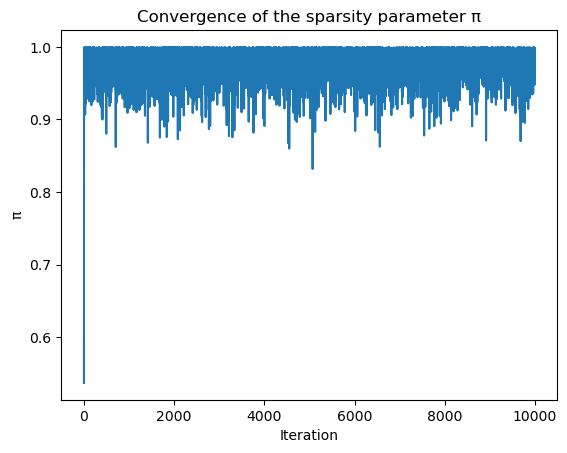

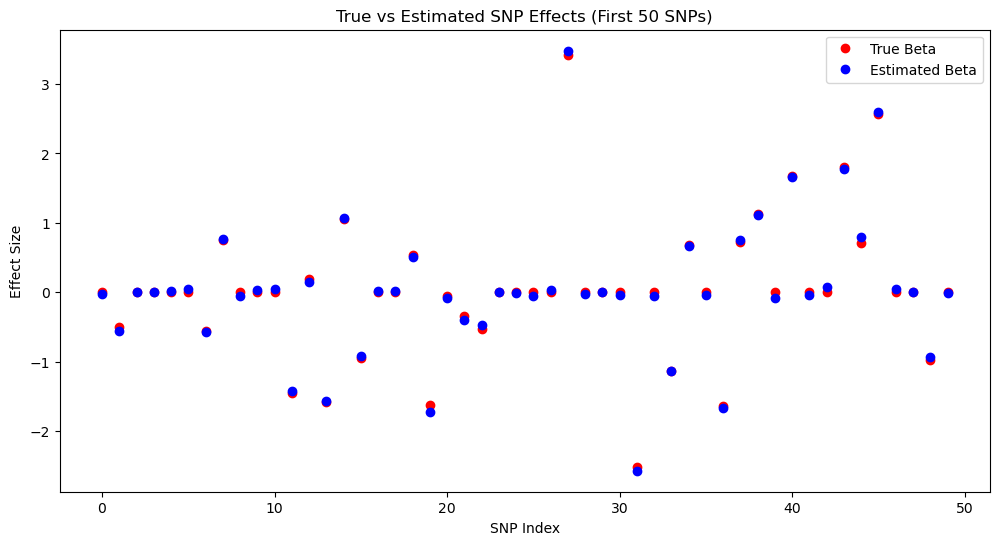

In [18]:
# 绘制稀疏性参数 pi 的收敛情况
plt.plot(pi_samples)
plt.title("Convergence of the sparsity parameter π")
plt.xlabel("Iteration")
plt.ylabel("π")
plt.show()

# 绘制真实和估计的 SNP 效应参数对比
plt.figure(figsize=(12, 6))
plt.plot(true_beta, 'ro', label="True Beta")
plt.plot(estimated_beta, 'bo', label="Estimated Beta")
plt.legend()
plt.xlabel("SNP Index")
plt.ylabel("Effect Size")
plt.title("True vs Estimated SNP Effects (First 50 SNPs)")
plt.show()


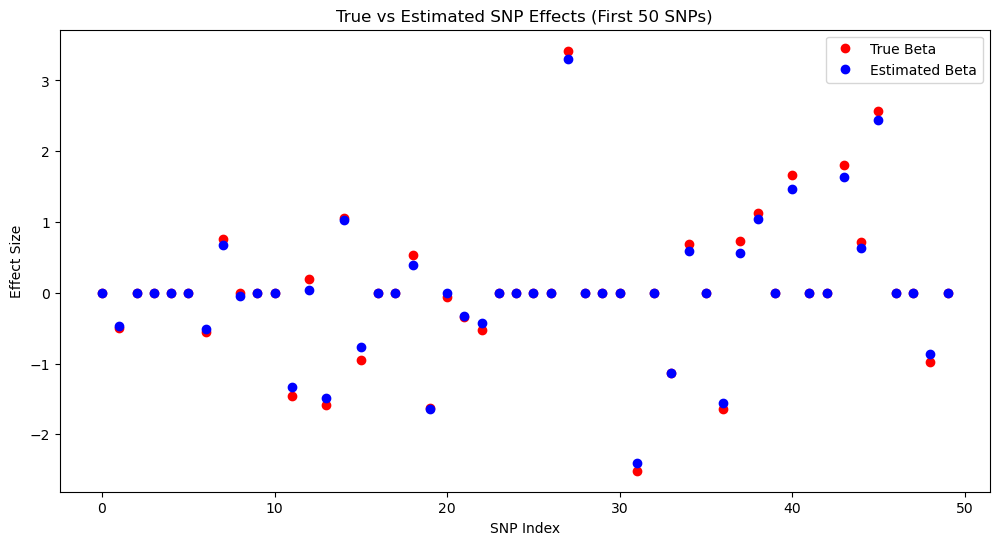

In [19]:
# 利用一般的lasso回归构建模型
from sklearn.linear_model import Lasso

# Apply Lasso regression from sklearn
lasso_model = Lasso(alpha=0.1, max_iter=10000)  # Using L1 regularization
lasso_model.fit(X[:, :n_snps], y)

# Estimate beta coefficients from Lasso
estimated_beta_lasso = lasso_model.coef_

# Compare the true and estimated beta for the first 10 SNPs
# true_beta[:10], estimated_beta_lasso[:10]
plt.figure(figsize=(12, 6))
plt.plot(true_beta, 'ro', label="True Beta")
plt.plot(estimated_beta_lasso, 'bo', label="Estimated Beta")
plt.legend()
plt.xlabel("SNP Index")
plt.ylabel("Effect Size")
plt.title("True vs Estimated SNP Effects (First 50 SNPs)")
plt.show()